# Further extending MUSE

## Adding a search space filter

In [1]:
from xarray import Dataset, DataArray

from muse.agents import Agent
from muse.filters import register_filter

@register_filter
def no_ccgt_filter(
    agent: Agent,
    search_space: DataArray,
    technologies: Dataset,
    market: Dataset
) -> DataArray:
    """Excludes gasCCGT."""
    dropped_tech = search_space.where(search_space.replacement != "windturbine", drop=True)
    return search_space & search_space.replacement.isin(dropped_tech.replacement)

In [2]:
import logging
from muse.mca import MCA
from muse import examples

# model_path = examples.copy_model(overwrite=True)
logging.getLogger("muse").setLevel(0)
mca = MCA.factory("model/settings.toml")
mca.run();

-- 2020-11-17 10:13:31 - muse.sectors.register - INFO
Sector legacy registered.

-- 2020-11-17 10:13:31 - muse.sectors.register - INFO
Sector preset registered, with alias presets.

-- 2020-11-17 10:13:31 - muse.sectors.register - INFO
Sector default registered.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 148.9679256735      
0.2598249156018     0.2598249156018     0.2598249156018     0.7495200004432  0.2598249156018     120.5733849622      
0.02399956829695    0.02399956829695    0.02399956829695    0.9210391224498  0.02399956829695    4.780663765494      
0.0181364461758     0.0181364461758     0.0181364461758     0.2509588065043  0.0181364461758     7.107141691547      
0.01499350833129    0.01499350833129    0.01499350833129    0.1921973185437  0.01499350833129    70.77614035582      
0.004968295711366   0.004968295711367   0.004968295711366   0.6857131120066  0.004968295711366   164.7472224003      
0.0006443120819652  0.0006443120819642  0.000644312081964   0.8804718592549  0.0006443120819672  289.7109372802      
2.427431365313e-06  2.427431365276e-06  2.42743136527e-06

-- 2020-11-17 10:13:40 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 359.2443189825      
0.2131118149695     0.2131118149695     0.2131118149695     0.7960343319409  0.2131118149695     262.2885392799      
0.05758094728718    0.05758094728718    0.05758094728718    0.7523513573813  0.05758094728718    13.16175379893      
0.01048349585899    0.01048349585899    0.01048349585899    0.8203940076989  0.01048349585899    9.036399448741      
0.009005598049604   0.009005598049604   0.009005598049604   0.1488155054953  0.009005598049604   19.40296370843      
0.002317604003518   0.002317604003518   0.002317604003518   0.8098673571979  0.002317604003518   226.5492459765      
0.0009784310820962  0.0009784310820963  0.0009784310820963  0.5991550275447  0.0009784310820971  289.4684048776      
0.0001326875071986  0.0001326875071986  0.000132687507198

-- 2020-11-17 10:13:53 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 359.2443189825      
0.2131118149695     0.2131118149695     0.2131118149695     0.7960343319409  0.2131118149695     262.2885392799      
0.05758094728718    0.05758094728718    0.05758094728718    0.7523513573813  0.05758094728718    13.16175379893      
0.01048349585899    0.01048349585899    0.01048349585899    0.8203940076989  0.01048349585899    9.036399448741      
0.009005598049604   0.009005598049604   0.009005598049604   0.1488155054953  0.009005598049604   19.40296370843      
0.002317604003518   0.002317604003518   0.002317604003518   0.8098673571979  0.002317604003518   226.5492459765      
0.0009784310820962  0.0009784310820963  0.0009784310820963  0.5991550275447  0.0009784310820971  289.4684048776      
0.0001326875071986  0.0001326875071986  0.000132687507198

-- 2020-11-17 10:14:07 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 414.316476678       
0.1943112264485     0.1943112264485     0.1943112264485     0.8115414580695  0.1943112264485     293.1180738751      
0.05737071259203    0.05737071259203    0.05737071259203    0.7291321197238  0.05737071259203    17.07106219013      
0.01062277327644    0.01062277327644    0.01062277327644    0.8173814867435  0.01062277327644    12.44885046687      
0.009064514495371   0.009064514495372   0.009064514495372   0.1550649500025  0.009064514495372   28.00868491133      
0.002334119807294   0.002334119807293   0.002334119807293   0.8051326751218  0.002334119807295   275.8552661516      
0.0006946146456239  0.0006946146456238  0.0006946146456238  0.7097377670861  0.0006946146456242  332.7560201847      
0.000253341221249   0.0002533412212489  0.000253341221248

-- 2020-11-17 10:14:19 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 414.316476678       
0.1943112264485     0.1943112264485     0.1943112264485     0.8115414580695  0.1943112264485     293.1180738751      
0.05737071259203    0.05737071259203    0.05737071259203    0.7291321197238  0.05737071259203    17.07106219013      
0.01062277327644    0.01062277327644    0.01062277327644    0.8173814867435  0.01062277327644    12.44885046687      
0.009064514495371   0.009064514495372   0.009064514495372   0.1550649500025  0.009064514495372   28.00868491133      
0.002334119807294   0.002334119807293   0.002334119807293   0.8051326751218  0.002334119807295   275.8552661516      
0.0006946146456239  0.0006946146456238  0.0006946146456238  0.7097377670861  0.0006946146456242  332.7560201847      
0.000253341221249   0.0002533412212489  0.000253341221248

-- 2020-11-17 10:14:29 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 454.6784294315      
0.1862232334687     0.1862232334687     0.1862232334687     0.8174567476576  0.1862232334687     282.4632604722      
0.02870747975048    0.02870747975048    0.02870747975048    0.8875534078522  0.02870747975048    46.09791383177      
0.009705128410004   0.009705128410004   0.009705128410004   0.6723641007507  0.009705128410004   35.13402203751      
0.007693915131578   0.007693915131578   0.007693915131578   0.2197837130033  0.007693915131578   80.93881539206      
0.001699044794839   0.001699044794837   0.001699044794837   0.8250841182677  0.00169904479484    298.2653882331      
0.0005650008980062  0.0005650008980057  0.0005650008980057  0.678565948553   0.0005650008980065  327.975809321       
0.0002196033953225  0.0002196033953223  0.000219603395322

-- 2020-11-17 10:14:36 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 454.6784294315      
0.1862232334687     0.1862232334687     0.1862232334687     0.8174567476576  0.1862232334687     282.4632604722      
0.02870747975048    0.02870747975048    0.02870747975048    0.8875534078522  0.02870747975048    46.09791383177      
0.009705128410004   0.009705128410004   0.009705128410004   0.6723641007507  0.009705128410004   35.13402203751      
0.007693915131578   0.007693915131578   0.007693915131578   0.2197837130033  0.007693915131578   80.93881539206      
0.001699044794839   0.001699044794837   0.001699044794837   0.8250841182677  0.00169904479484    298.2653882331      
0.0005650008980062  0.0005650008980057  0.0005650008980057  0.678565948553   0.0005650008980065  327.975809321       
0.0002196033953225  0.0002196033953223  0.000219603395322

-- 2020-11-17 10:14:44 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 506.4464461439      
0.1717574295871     0.1717574295871     0.1717574295871     0.8319963473544  0.1717574295871     268.7406800963      
0.06638577511032    0.06638577511032    0.06638577511033    0.6490768395246  0.06638577511033    376.5617800925      
0.0108119991109     0.01081199911089    0.01081199911089    0.8457086649906  0.01081199911089    156.44831956        
0.006166341998836   0.006166341998834   0.006166341998835   0.4575243211097  0.006166341998835   243.5697308399      
0.0005157722017999  0.0005157722017955  0.0005157722017955  0.9303097249327  0.0005157722018036  353.933860755       
7.752032087913e-08  7.75203208986e-08   7.752032089586e-08  0.9998584907938  7.75203208902e-08   354.2607816225      
1.875610793654e-11  1.875609893145e-11  1.875610020548e-1

-- 2020-11-17 10:14:53 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 506.4464461439      
0.1717574295871     0.1717574295871     0.1717574295871     0.8319963473544  0.1717574295871     268.7406800963      
0.06638577511032    0.06638577511032    0.06638577511033    0.6490768395246  0.06638577511033    376.5617800925      
0.0108119991109     0.01081199911089    0.01081199911089    0.8457086649906  0.01081199911089    156.44831956        
0.006166341998836   0.006166341998834   0.006166341998835   0.4575243211097  0.006166341998835   243.5697308399      
0.0005157722017999  0.0005157722017955  0.0005157722017955  0.9303097249327  0.0005157722018036  353.933860755       
7.752032087913e-08  7.75203208986e-08   7.752032089586e-08  0.9998584907938  7.75203208902e-08   354.2607816225      
1.875610793654e-11  1.875609893145e-11  1.875610020548e-1

-- 2020-11-17 10:15:01 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 568.8949309456      
0.1574999940443     0.1574999940443     0.1574999940443     0.8462995490748  0.1574999940443     259.3692323549      
0.07523425397025    0.07523425397025    0.07523425397025    0.5547720211262  0.07523425397025    453.5904211877      
0.01015218722862    0.01015218722862    0.01015218722862    0.8831324835902  0.01015218722862    172.5109988087      
0.005597873343747   0.005597873343747   0.005597873343747   0.4782155730769  0.005597873343747   257.1812475882      
0.0004682435100659  0.0004682435100634  0.0004682435100634  0.9301215087302  0.000468243510069   357.0084554784      
6.611502592752e-08  6.611502591615e-08  6.611502591873e-08  0.999863385888   6.611502594636e-08  355.7877874388      
7.555502313764e-12  7.555508723405e-12  7.555505999397e-1

-- 2020-11-17 10:15:12 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 568.8949309456      
0.1574999940443     0.1574999940443     0.1574999940443     0.8462995490748  0.1574999940443     259.3692323549      
0.07523425397025    0.07523425397025    0.07523425397025    0.5547720211262  0.07523425397025    453.5904211877      
0.01015218722862    0.01015218722862    0.01015218722862    0.8831324835902  0.01015218722862    172.5109988087      
0.005597873343747   0.005597873343747   0.005597873343747   0.4782155730769  0.005597873343747   257.1812475882      
0.0004682435100659  0.0004682435100634  0.0004682435100634  0.9301215087302  0.000468243510069   357.0084554784      
6.611502592752e-08  6.611502591615e-08  6.611502591873e-08  0.999863385888   6.611502594636e-08  355.7877874388      
7.555502313764e-12  7.555508723405e-12  7.555505999397e-1

-- 2020-11-17 10:15:20 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 647.4402248427      
0.1042702416317     0.1042702416317     0.1042702416317     0.9044651903652  0.1042702416317     197.7436068274      
0.04330783922975    0.04330783922975    0.04330783922975    0.6213338928986  0.04330783922975    554.8458695929      
0.02029339907042    0.02029339907042    0.02029339907042    0.5546164251713  0.02029339907042    887.503418141       
0.002059630009005   0.002059630008646   0.002059630008646   0.9123945707354  0.002059630008855   1773.497308596      
1.96164830749e-06   1.961648306624e-06  1.961648306623e-06  0.9995475315428  1.96164830693e-06   1899.795955905      
1.183904657193e-10  1.183907029537e-10  1.183907180056e-10  0.9999396473343  1.183903667831e-10  1900.055708261      
Optimization terminated successfully.
         Current fu

-- 2020-11-17 10:15:27 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 647.4402248427      
0.1042702416317     0.1042702416317     0.1042702416317     0.9044651903652  0.1042702416317     197.7436068274      
0.04330783922975    0.04330783922975    0.04330783922975    0.6213338928986  0.04330783922975    554.8458695929      
0.02029339907042    0.02029339907042    0.02029339907042    0.5546164251713  0.02029339907042    887.503418141       
0.002059630009005   0.002059630008646   0.002059630008646   0.9123945707354  0.002059630008855   1773.497308596      
1.96164830749e-06   1.961648306624e-06  1.961648306623e-06  0.9995475315428  1.96164830693e-06   1899.795955905      
1.183904657193e-10  1.183907029537e-10  1.183907180056e-10  0.9999396473343  1.183903667831e-10  1900.055708261      
Optimization terminated successfully.
         Current fu

-- 2020-11-17 10:15:34 - muse.mca - WARNING
Check growth constraints for wind.



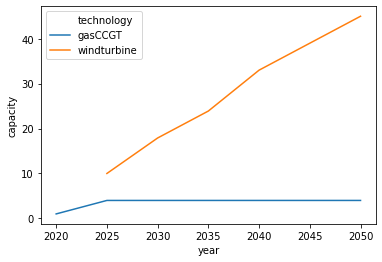

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot

results = pd.read_csv("Results/MCACapacity.csv")
results
sns.lineplot(data=results[results.sector=="power"], x='year', y='capacity', hue='technology')

## Registering a custom decision function

Next, we would like to add an additional decision function. A decision function is a transformation applied to aggregate multiple objectives into a single objective during agent investment. For example, through the use of a weighted sum. 

In this example, we would like to take the median objective. However, the functions predefined in MUSE don't include this functionality. MUSE contains examples such as the mean, weighted sum and a single objective. Therefore we will have to register and create our own.

Now, we create our new `median_objective` function:

In [4]:
from muse.decisions import register_decision
from typing import Any
from xarray import Dataset

@register_decision
def median_objective(
    objectives: Dataset,
    parameters: Any,
    **kwargs
) -> DataArray:
    from xarray import concat
#     print("objectives: {}".format(objectives))
    allobjectives = concat(objectives.data_vars.values(), dim="concat_var")
#     print("allobjectives: {}".format(allobjectives))
    return allobjectives.median(set(allobjectives.dims) - {"asset", "replacement"})

After importing the decorator function, `register_decision`, and ensuring that we decorate our new function with  `@register_decision`, we are able to create our new function as above.

Our new function `median_objective` modifies the `mean` function already built into MUSE, with one difference. Replacing the return value, from `allobjectives.mean` to `allobjectives.mean`.

    @register_decision
    def mean(objectives: Dataset, *args, **kwargs) -> DataArray:
        """Mean over objectives."""
        from xarray import concat

        allobjectives = concat(objectives.data_vars.values(), dim="concat_var")
        return allobjectives.mean(set(allobjectives.dims) - {"asset", "replacement"})
        
Of course, you are free to make your functions as complicated as you like, depending on your own requirements.

Next, we must edit our `Agents.csv` file. We will modify the `default` example for this tutorial. We change the first two entry rows, to be as follows:

    Agent1,A1,1,R1,LCOE,NPV,EAC,1,,,FALSE,,,all,median_objective,1,-1,inf,New
    Agent2,A1,2,R1,LCOE,NPV,EAC,1,,,FALSE,,,all,median_objective,1,-1,inf,Retrofit

Here, we add the NPV and EAC decision metrics, as well as replacing the `singleObj` `DecisionMethod` to `median_objective`.

Now we are able to run our modified model as before:

In [5]:
logging.getLogger("muse").setLevel(0)
mca = MCA.factory("../tutorial-code/new-decision-metric/settings.toml")
mca.run();

Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -148.9679256735     
0.3657691176602     0.3657691176602     0.3657691176602     0.6461791108907  0.3657691176602     -548.8914979349     
0.1000043035782     0.1000043035777     0.1000043035777     0.7604847797418  0.1000043035619     -3361.518257277     
0.001844661102721   0.001844661102719   0.00184466110272    0.9823824953188  0.001844661102586   -7298.96931032      
2.11291425011e-07   2.112914038367e-07  2.11291404318e-07   0.9998860005467  2.112909086624e-07  -7448.378947249     
9.535648376629e-12  9.605633214814e-12  9.605546869204e-12  0.9999545384645  1.124992881202e-11  -7448.396282893     
Optimization terminated successfully.
         Current function value: -7448.396283
         Iterations: 5
Primal Feasibility  Dual Feasibility    Duality Gap         Step    

-- 2020-11-17 10:15:47 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-17 10:15:51 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-17 10:15:55 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -414.316476678      
0.4585283470439     0.4585283470439     0.4585283470439     0.5527682928622  0.4585283470439     -741.6114429279     
0.2354108323407     0.2354108323407     0.2354108323407     0.5152287322953  0.2354108323407     -2570.500752767     
0.03105424181754    0.03105424182074    0.03105424182074    0.8925812544063  0.03105424187631    -8641.587344303     
6.26592921329e-05   6.265929213082e-05  6.265929213038e-05  0.9980256554285  6.265929198769e-05  -10353.88210989     
3.133914375588e-09  3.13391872046e-09   3.133919425827e-09  0.9999499847834  3.134029083494e-09  -10357.91171536     
Optimization terminated successfully.
         Current function value: -10357.911715
         Iterations: 5
Primal Feasibility  Dual Feasibility    Duality Gap         Step   

-- 2020-11-17 10:16:02 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -414.316476678      
0.4585283470439     0.4585283470439     0.4585283470439     0.5527682928622  0.4585283470439     -741.6114429279     
0.2354108323407     0.2354108323407     0.2354108323407     0.5152287322953  0.2354108323407     -2570.500752767     
0.03105424181754    0.03105424182074    0.03105424182074    0.8925812544063  0.03105424187631    -8641.587344303     
6.26592921329e-05   6.265929213082e-05  6.265929213038e-05  0.9980256554285  6.265929198769e-05  -10353.88210989     
3.133914375588e-09  3.13391872046e-09   3.133919425827e-09  0.9999499847834  3.134029083494e-09  -10357.91171536     
Optimization terminated successfully.
         Current function value: -10357.911715
         Iterations: 5
Primal Feasibility  Dual Feasibility    Duality Gap         Step   

-- 2020-11-17 10:16:09 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-17 10:16:12 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-17 10:16:16 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -506.4464461439     
0.446505902934      0.446505902934      0.446505902934      0.5642732200245  0.446505902934      -809.5686919879     
0.2673350612728     0.2673350612728     0.2673350612728     0.4284345629888  0.2673350612728     -2215.865086186     
0.03979058009978    0.03979058009978    0.03979058009978    0.8832611968325  0.03979058009979    -9839.011456889     
0.0001372304993751  0.0001372304993775  0.0001372304993776  0.9967954309289  0.0001372304994594  -12649.34849175     
6.870083178268e-09  6.870065556438e-09  6.870065297203e-09  0.9999499379902  6.869623470412e-09  -12661.16056201     
Optimization terminated successfully.
         Current function value: -12661.160562
         Iterations: 5


-- 2020-11-17 10:16:21 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -506.4464461439     
0.446505902934      0.446505902934      0.446505902934      0.5642732200245  0.446505902934      -809.5686919879     
0.2673350612728     0.2673350612728     0.2673350612728     0.4284345629888  0.2673350612728     -2215.865086186     
0.03979058009978    0.03979058009978    0.03979058009978    0.8832611968325  0.03979058009979    -9839.011456889     
0.0001372304993751  0.0001372304993775  0.0001372304993776  0.9967954309289  0.0001372304994594  -12649.34849175     
6.870083178268e-09  6.870065556438e-09  6.870065297203e-09  0.9999499379902  6.869623470412e-09  -12661.16056201     
Optimization terminated successfully.
         Current function value: -12661.160562
         Iterations: 5


-- 2020-11-17 10:16:26 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -161.1096265797     
0.09454942551446    0.09454942551446    0.09454942551447    0.9096785976291  0.09454942551446    -329.7080177707     
0.04464774200804    0.04464774200804    0.04464774200804    0.5625946589872  0.04464774200804    -268.1572658531     
0.02080011379452    0.02080011379449    0.02080011379449    0.5732522076751  0.02080011379449    -174.2747977742     
0.001599890900803   0.0015998909008     0.001599890900801   0.9273662793127  0.0015998909008     -168.2538863814     
3.696250717956e-06  3.696250212213e-06  3.696250212205e-06  0.9987337462974  3.696289316701e-06  -167.1110220166     
1.848456124938e-10  1.848454740263e-10  1.84845476646e-10   0.9999499910755  1.848436804684e-10  -167.1095525767     
Optimization terminated successfully.
         Current fu

-- 2020-11-17 10:16:31 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -161.1096265797     
0.09454942551446    0.09454942551446    0.09454942551447    0.9096785976291  0.09454942551446    -329.7080177707     
0.04464774200804    0.04464774200804    0.04464774200804    0.5625946589872  0.04464774200804    -268.1572658531     
0.02080011379452    0.02080011379449    0.02080011379449    0.5732522076751  0.02080011379449    -174.2747977742     
0.001599890900803   0.0015998909008     0.001599890900801   0.9273662793127  0.0015998909008     -168.2538863814     
3.696250717956e-06  3.696250212213e-06  3.696250212205e-06  0.9987337462974  3.696289316701e-06  -167.1110220166     
1.848456124938e-10  1.848454740263e-10  1.84845476646e-10   0.9999499910755  1.848436804684e-10  -167.1095525767     
Optimization terminated successfully.
         Current fu

-- 2020-11-17 10:16:36 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -647.4402248427     
0.4065456929991     0.4065456929991     0.4065456929991     0.6047403293196  0.4065456929991     -964.3289978473     
0.2501040527429     0.2501040527429     0.2501040527429     0.413621474079   0.2501040527429     -2487.635503728     
0.03870786985488    0.03870786985488    0.03870786985488    0.8799396700439  0.03870786985492    -12173.41702855     
0.000166105212302   0.0001661052123006  0.0001661052123006  0.9964417810524  0.0001661052122337  -16165.0600004      
8.372410202887e-09  8.372406318873e-09  8.372405899595e-09  0.9999495962205  8.372263738081e-09  -16186.00456468     
Optimization terminated successfully.
         Current function value: -16186.004565
         Iterations: 5


-- 2020-11-17 10:16:42 - muse.mca - WARNING
Check growth constraints for wind.



Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -647.4402248427     
0.4065456929991     0.4065456929991     0.4065456929991     0.6047403293196  0.4065456929991     -964.3289978473     
0.2501040527429     0.2501040527429     0.2501040527429     0.413621474079   0.2501040527429     -2487.635503728     
0.03870786985488    0.03870786985488    0.03870786985488    0.8799396700439  0.03870786985492    -12173.41702855     
0.000166105212302   0.0001661052123006  0.0001661052123006  0.9964417810524  0.0001661052122337  -16165.0600004      
8.372410202887e-09  8.372406318873e-09  8.372405899595e-09  0.9999495962205  8.372263738081e-09  -16186.00456468     
Optimization terminated successfully.
         Current function value: -16186.004565
         Iterations: 5


-- 2020-11-17 10:16:47 - muse.mca - WARNING
Check growth constraints for wind.



Again, we visualise the power sector:

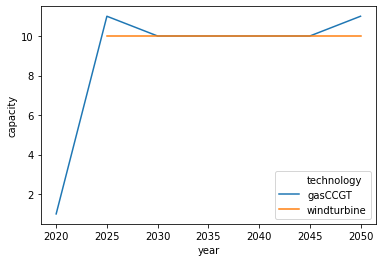

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot

results = pd.read_csv("Results/MCACapacity.csv")
results
sns.lineplot(data=results[results.sector=="power"], x='year', y='capacity', hue='technology')

We see a different scenario emerge through these different decision metrics. This shows the importance of decision metrics when making long-term investment decisions.

## End of tutorials

In these tutorials you have seen the ways in which you can modify MUSE. All of these methods can be combined and extended to make as simple or complex model as you wish. Feel free to experiment and come up with your own ideas for your future work!

For further information, we refer you to the API in the next section.